In [1]:
#imports necessary libraries
import os                  
import numpy as np       
import pandas as pd            
import matplotlib.pyplot as plt  
import seaborn as sns
 
#imports for scikit-learn model training
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

#imports for PyTorch and torchvision for model training
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from PIL import Image

In [7]:
#Importing the CSV file and checking if the image files exist
df = pd.read_csv("image_labels.csv") 
base_path = "augmented_images/augmented_images1"
df['filepath'] = df['filename'].apply(lambda x: os.path.join(base_path, *x.split('/')))
print(df['filepath'].apply(os.path.exists).value_counts())

filepath
True    13640
Name: count, dtype: int64


In [8]:
#Loading and preprocessing images
def load_images(df):
    images = []
    labels = df['label'].values
    for path in df['filepath']:
        img = Image.open(path).convert('L') 
        img = img.resize((28,28))
        images.append(np.array(img))
    return np.array(images), labels

X, y = load_images(df)
X = X / 255.0
X = np.expand_dims(X, -1)

#Encoding labels
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

In [9]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_encoded,
    test_size=0.30,
    random_state=42,
    stratify=y_encoded
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,
    random_state=42
)

print("Treino:", X_train.shape)
print("Validação:", X_val.shape)
print("Teste:", X_test.shape)

Treino: (9548, 28, 28, 1)
Validação: (2046, 28, 28, 1)
Teste: (2046, 28, 28, 1)


Acurácia RF: 0.31671554252199413


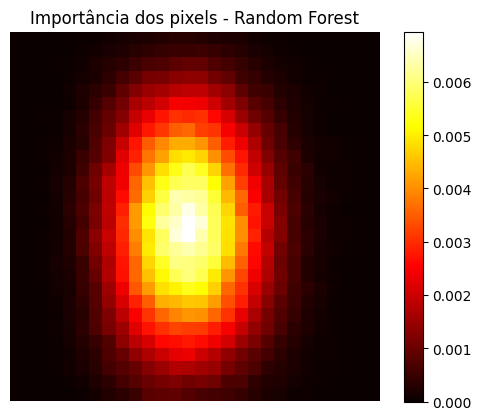

In [10]:
#random forest training
X_train_rf = X_train.reshape(X_train.shape[0], -1)
X_val_rf   = X_val.reshape(X_val.shape[0], -1)
X_test_rf  = X_test.reshape(X_test.shape[0], -1)


rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train_rf, y_train)


y_pred = rf.predict(X_test_rf)
acc = accuracy_score(y_test, y_pred)

print("Acurácia RF:", acc)


importances = rf.feature_importances_.reshape(28, 28)

plt.imshow(importances, cmap="hot")
plt.colorbar()
plt.title("Importância dos pixels - Random Forest")
plt.axis("off")
plt.show()


In [11]:
# Defining CNN architectures
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
 
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
 
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
 
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 62)
        )
 
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x
 
 
class LeNet5(nn.Module):
    def __init__(self, num_classes=62):
        super().__init__()
 
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.pool = nn.AvgPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
 
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)
 
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
 
       
        x = x.reshape(x.size(0), -1)
 
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [12]:
# TRAINING-1 Simple CNN model
# Hyperparameters
epochs = 50
batch_size = 64
learning_rate = 0.001
model = LeNet5()
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Converted to PyTorch (fixed error of float_tensor and edited for 2º dimension order)
X_train_t = torch.from_numpy(X_train).permute(0, 3, 1, 2).float()
X_val_t   = torch.from_numpy(X_val).permute(0, 3, 1, 2).float()
X_test_t  = torch.from_numpy(X_test).permute(0, 3, 1, 2).float()

y_train_t = torch.from_numpy(y_train).long()
y_val_t   = torch.from_numpy(y_val).long()
y_test_t  = torch.from_numpy(y_test).long()

# Datasets e DataLoaders
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset   = TensorDataset(X_val_t, y_val_t)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size)

# Model, loss and optimizer
model = SimpleCNN()  # ou LeNet5(num_classes=62)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Treino
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            outputs = model(batch_x)
            _, predicted = torch.max(outputs, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
    
    val_acc = 100 * correct / total
    print(f"Epoch {epoch+1}/{epochs} - Loss: {train_loss/len(train_loader):.4f} - Val Acc: {val_acc:.2f}%")

Epoch 1/50 - Loss: 4.0816 - Val Acc: 4.74%
Epoch 2/50 - Loss: 3.6961 - Val Acc: 11.39%
Epoch 3/50 - Loss: 3.3234 - Val Acc: 19.40%
Epoch 4/50 - Loss: 2.8393 - Val Acc: 25.76%
Epoch 5/50 - Loss: 2.4620 - Val Acc: 31.48%
Epoch 6/50 - Loss: 2.1988 - Val Acc: 37.78%
Epoch 7/50 - Loss: 1.9803 - Val Acc: 41.54%
Epoch 8/50 - Loss: 1.7855 - Val Acc: 45.11%
Epoch 9/50 - Loss: 1.6299 - Val Acc: 48.48%
Epoch 10/50 - Loss: 1.4661 - Val Acc: 51.52%
Epoch 11/50 - Loss: 1.3609 - Val Acc: 53.71%
Epoch 12/50 - Loss: 1.2622 - Val Acc: 54.01%
Epoch 13/50 - Loss: 1.1883 - Val Acc: 55.47%
Epoch 14/50 - Loss: 1.1257 - Val Acc: 55.18%
Epoch 15/50 - Loss: 1.0620 - Val Acc: 56.74%
Epoch 16/50 - Loss: 1.0111 - Val Acc: 57.04%
Epoch 17/50 - Loss: 0.9728 - Val Acc: 56.74%
Epoch 18/50 - Loss: 0.9230 - Val Acc: 58.21%
Epoch 19/50 - Loss: 0.8856 - Val Acc: 57.87%
Epoch 20/50 - Loss: 0.8619 - Val Acc: 59.29%
Epoch 21/50 - Loss: 0.8279 - Val Acc: 59.29%
Epoch 22/50 - Loss: 0.7872 - Val Acc: 60.95%
Epoch 23/50 - Loss: 

Test accuracy: 60.31%


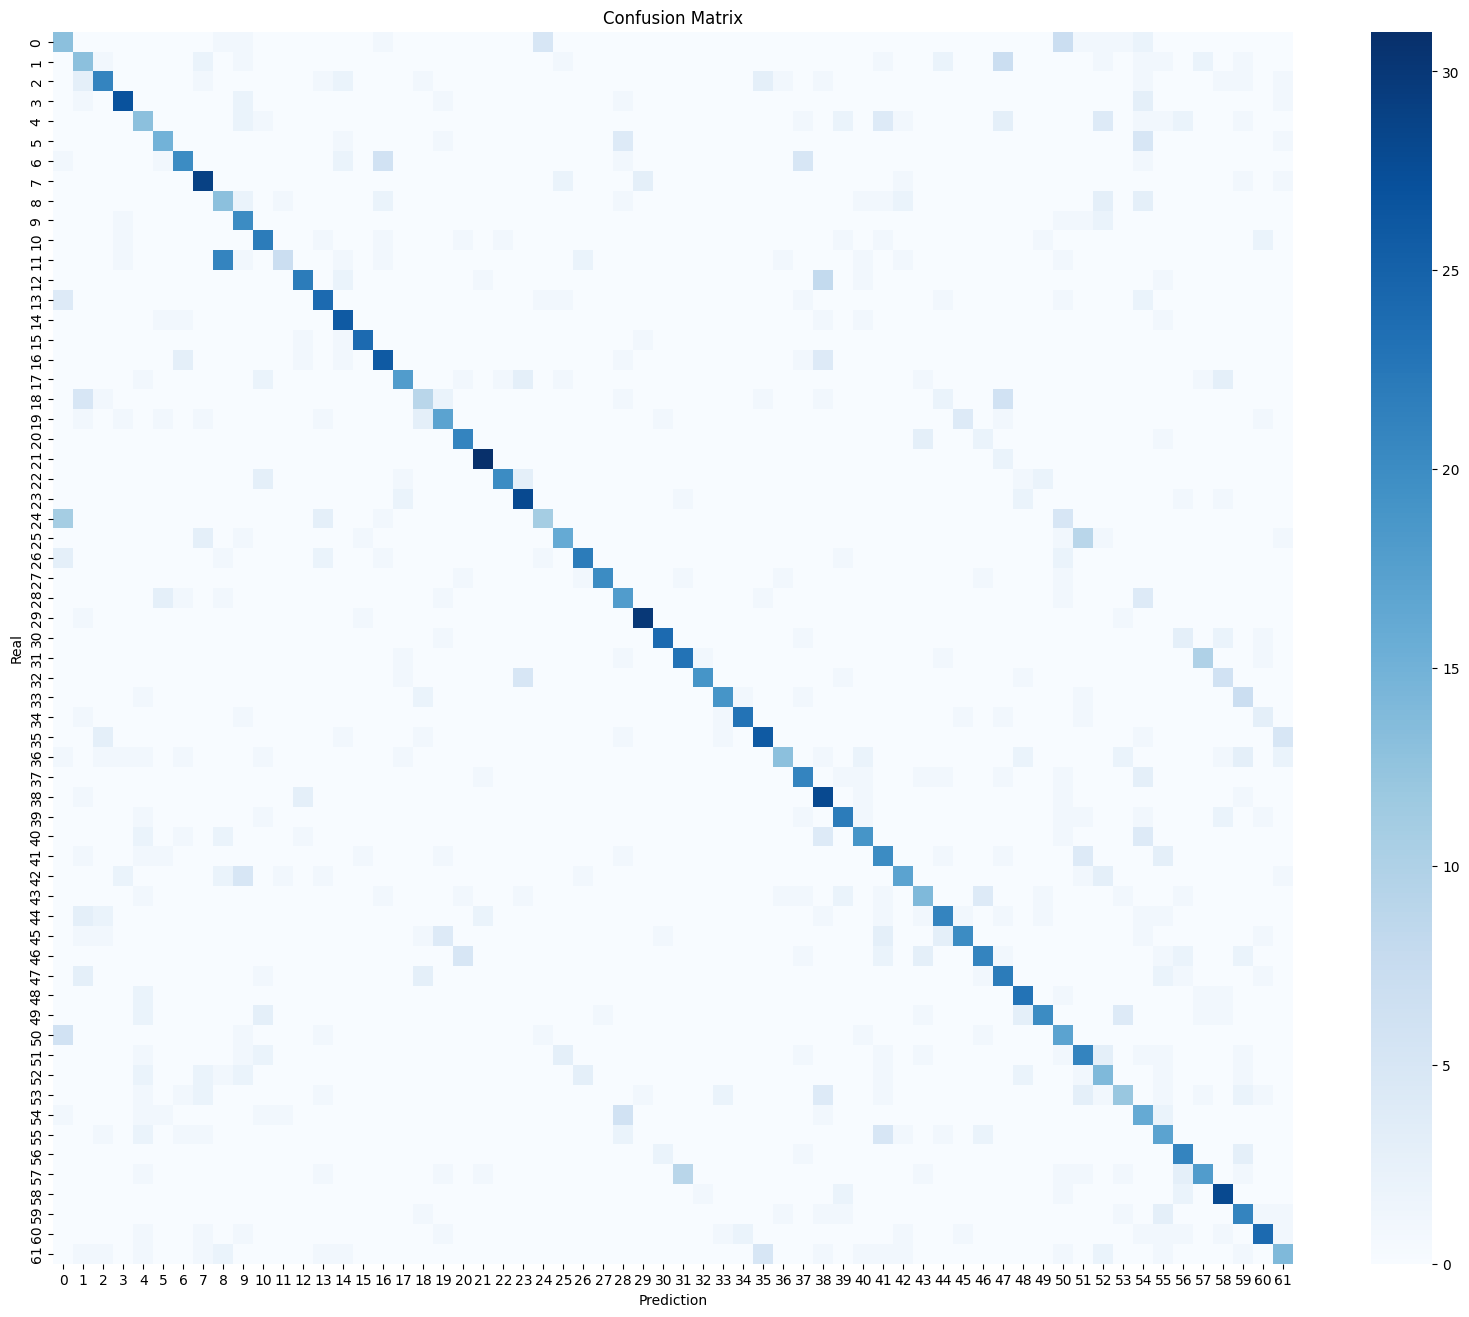

              precision    recall  f1-score   support

           0       0.33      0.39      0.36        33
           1       0.37      0.38      0.38        34
           2       0.66      0.55      0.60        38
           3       0.79      0.75      0.77        36
           4       0.37      0.36      0.37        36
           5       0.65      0.56      0.60        27
           6       0.69      0.54      0.61        37
           7       0.67      0.78      0.72        37
           8       0.30      0.45      0.36        29
           9       0.49      0.80      0.61        25
      A_caps       0.59      0.69      0.64        32
      B_caps       0.70      0.18      0.29        38
      C_caps       0.79      0.63      0.70        35
      D_caps       0.65      0.69      0.67        35
      E_caps       0.68      0.84      0.75        31
      F_caps       0.89      0.89      0.89        27
      G_caps       0.65      0.70      0.68        37
      H_caps       0.75    

In [13]:
# TRAINING-1 Result analysis
model.eval()
with torch.no_grad():
    outputs = model(X_test_t)
    _, predicted = torch.max(outputs, 1)
    test_acc = 100 * (predicted == y_test_t).sum().item() / len(y_test_t)
    print(f"Test accuracy: {test_acc:.2f}%")

# Confusion Matrix
cm = confusion_matrix(y_test, predicted.numpy())
plt.figure(figsize=(20,16))
sns.heatmap(cm, annot=False, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Prediction")
plt.ylabel("Real")
plt.show()

print(classification_report(y_test, predicted.numpy(), target_names=encoder.classes_))

In [14]:
# IPROVED-TRAINING-2 Data Augmentation, Dropout, Callbacks and + epochs
# 1. recall data if not working (makes da cell independent)
if 'X_train' not in locals() or 'X_val' not in locals():
    print("variables not found in memory. Reloading dataset...")
    
    df = pd.read_csv("image_labels.csv")
    base_path = "augmented_images/augmented_images1"
    df['filepath'] = df['filename'].apply(lambda x: os.path.join(base_path, *x.split('/')))
    
    def load_images(df):
        images = []
        labels = df['label'].values
        for path in df['filepath']:
            img = Image.open(path).convert('L')
            img = img.resize((28, 28))
            images.append(np.array(img))
        return np.array(images), labels

    X, y = load_images(df)
    X = X / 255.0
    X = np.expand_dims(X, -1)

    encoder = LabelEncoder()
    y_encoded = encoder.fit_transform(y)
    
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y_encoded, test_size=0.30, random_state=42, stratify=y_encoded
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.50, random_state=42
    )
    
    print("Dataset loaded successfully.")
    print(f"Treino: {X_train.shape}, Validação: {X_val.shape}, Teste: {X_test.shape}")
    print(f"Número de classes: {len(np.unique(y_encoded))}")
else:
    print("dataset variables found in memory. Proceeding to training...")

# 2. Convert to pytorch tensors (NCHW, float)
X_train_t = torch.from_numpy(X_train).permute(0, 3, 1, 2).float()
X_val_t   = torch.from_numpy(X_val).permute(0, 3, 1, 2).float()
X_test_t  = torch.from_numpy(X_test).permute(0, 3, 1, 2).float()

y_train_t = torch.from_numpy(y_train).long()
y_val_t   = torch.from_numpy(y_val).long()
y_test_t  = torch.from_numpy(y_test).long()


# 3. DATA AUGMENTATION (only in training)

#train_transform = transforms.Compose([
    #transforms.RandomRotation(10),                          
    #transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  
#]) - OLD CODE TAHT WORSEN THE RESULTS BY 51%

train_transform = transforms.Compose([
    transforms.ToPILImage(),                          
    transforms.RandomRotation(15),                     
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Shift 10%
    transforms.RandomApply([transforms.RandomResizedCrop(28, scale=(0.9, 1.0))], p=0.5),  
    transforms.ToTensor(),                            
])

class AugmentedDataset(TensorDataset):
    def __init__(self, images, labels, transform=None):
        super().__init__(images, labels)
        self.transform = transform
    
    def __getitem__(self, index):
        img, label = super().__getitem__(index)

        # """img, label = super().__getitem__(index)""" - OLD CODE TAHT WORSEN THE RESULTS BY 51%
        img = img.squeeze(0)  
        if self.transform is not None:
            img = self.transform(img)
        return img, label

# Datasets
train_dataset = AugmentedDataset(X_train_t, y_train_t, transform=train_transform)
val_dataset   = TensorDataset(X_val_t, y_val_t)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=False)


# 4. improved model with Dropout and correct forward
class SimpleCNNImproved(nn.Module):
    def __init__(self, num_classes=62):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = SimpleCNNImproved()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)


# 5. training with callbacks
best_val_acc = 0.0
patience_es = 7
counter = 0
max_epochs = 50

print("\nStarting training n2...\n")

for epoch in range(max_epochs):
    model.train()
    train_loss = 0.0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    # validation
    model.eval()
    correct = 0
    total = 0
    val_loss = 0.0
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
    
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    val_acc = 100 * correct / total
    
    print(f"Epoch {epoch+1:2d}/{max_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    
    # Callbacks
    scheduler.step(avg_val_loss)
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        counter = 0
        torch.save(model.state_dict(), 'best_model_improved2.pth')
        print(f"   >>> new best model saved: {best_val_acc:.2f}%")
    else:
        counter += 1
        if counter >= patience_es:
            print(f"   >>> Early Stopping! There wasn't any improvement in last {patience_es} epochs.")
            break

print(f"\nbest val acc achieved: {best_val_acc:.2f}%")
print("Modelo salvo")

dataset variables found in memory. Proceeding to training...

Starting training n2...

Epoch  1/50 | Train Loss: 4.1296 | Val Loss: 4.1213 | Val Acc: 1.86%
   >>> new best model saved: 1.86%
Epoch  2/50 | Train Loss: 4.0834 | Val Loss: 3.9780 | Val Acc: 4.25%
   >>> new best model saved: 4.25%
Epoch  3/50 | Train Loss: 3.9364 | Val Loss: 3.7996 | Val Acc: 6.70%
   >>> new best model saved: 6.70%
Epoch  4/50 | Train Loss: 3.7940 | Val Loss: 3.5921 | Val Acc: 11.68%
   >>> new best model saved: 11.68%
Epoch  5/50 | Train Loss: 3.6101 | Val Loss: 3.2333 | Val Acc: 17.89%
   >>> new best model saved: 17.89%
Epoch  6/50 | Train Loss: 3.3622 | Val Loss: 2.9755 | Val Acc: 22.24%
   >>> new best model saved: 22.24%
Epoch  7/50 | Train Loss: 3.2251 | Val Loss: 2.7699 | Val Acc: 25.95%
   >>> new best model saved: 25.95%
Epoch  8/50 | Train Loss: 3.1241 | Val Loss: 2.6266 | Val Acc: 28.64%
   >>> new best model saved: 28.64%
Epoch  9/50 | Train Loss: 3.0355 | Val Loss: 2.5247 | Val Acc: 32.31%
 

In [15]:
# TRAIN 3 – Dropout only (no data augmentation, no callbacks beyond scheduler)

# 1. Load dataset if not already in memory
if 'X_train' not in locals() or 'X_val' not in locals():
    print("Data not found. Reloading dataset...")

    df = pd.read_csv("image_labels.csv")
    base_path = "augmented_images/augmented_images1"
    df['filepath'] = df['filename'].apply(lambda x: os.path.join(base_path, *x.split('/')))

    def load_images(df):
        images = []
        labels = df['label'].values
        for path in df['filepath']:
            img = Image.open(path).convert('L')
            img = img.resize((28, 28))
            images.append(np.array(img))
        return np.array(images), labels

    X, y = load_images(df)
    X = X / 255.0
    X = np.expand_dims(X, -1)

    encoder = LabelEncoder()
    y_encoded = encoder.fit_transform(y)

    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y_encoded, test_size=0.30, random_state=42, stratify=y_encoded
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.50, random_state=42
    )

    print("Dataset loaded successfully")
    print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
    print(f"Number of classes: {len(np.unique(y_encoded))}")
else:
    print("Dataset already loaded. Using existing variables.")


# 2. Convert numpy arrays to PyTorch tensors (NCHW)
X_train_t = torch.from_numpy(X_train).permute(0, 3, 1, 2).float()
X_val_t   = torch.from_numpy(X_val).permute(0, 3, 1, 2).float()
X_test_t  = torch.from_numpy(X_test).permute(0, 3, 1, 2).float()

y_train_t = torch.from_numpy(y_train).long()
y_val_t   = torch.from_numpy(y_val).long()
y_test_t  = torch.from_numpy(y_test).long()


# 3. Datasets and dataloaders
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset   = TensorDataset(X_val_t, y_val_t)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=False)


# 4. CNN model with dropout
class SimpleCNNImproved(nn.Module):
    def __init__(self, num_classes=62):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


model = SimpleCNNImproved()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', patience=3, factor=0.5
)


# 5. Training loop with validation and early stopping
best_val_acc = 0.0
patience_es = 7
counter = 0
max_epochs = 50

print("\nStarting training...\n")

for epoch in range(max_epochs):
    model.train()
    train_loss = 0.0

    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    correct = 0
    total = 0
    val_loss = 0.0

    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()

    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    val_acc = 100 * correct / total

    print(
        f"Epoch {epoch+1:2d}/{max_epochs} | "
        f"Train Loss: {avg_train_loss:.4f} | "
        f"Val Loss: {avg_val_loss:.4f} | "
        f"Val Acc: {val_acc:.2f}%"
    )

    scheduler.step(avg_val_loss)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        counter = 0
        torch.save(model.state_dict(), 'best_model_improved3.pth')
        print(f"   >>> New best model saved! Val Acc: {best_val_acc:.2f}%")
    else:
        counter += 1
        if counter >= patience_es:
            print(f"   >>> Early stopping after {patience_es} epochs without improvement.")
            break


print(f"\nTraining finished. Best Val Acc: {best_val_acc:.2f}%")
print("Model saved as 'best_model_improved3.pth'")


Dataset already loaded. Using existing variables.

Starting training...

Epoch  1/50 | Train Loss: 4.1299 | Val Loss: 4.1204 | Val Acc: 2.10%
   >>> New best model saved! Val Acc: 2.10%
Epoch  2/50 | Train Loss: 4.0726 | Val Loss: 3.9232 | Val Acc: 6.26%
   >>> New best model saved! Val Acc: 6.26%
Epoch  3/50 | Train Loss: 3.8628 | Val Loss: 3.6953 | Val Acc: 8.26%
   >>> New best model saved! Val Acc: 8.26%
Epoch  4/50 | Train Loss: 3.6584 | Val Loss: 3.4562 | Val Acc: 14.81%
   >>> New best model saved! Val Acc: 14.81%
Epoch  5/50 | Train Loss: 3.4235 | Val Loss: 3.1611 | Val Acc: 19.84%
   >>> New best model saved! Val Acc: 19.84%
Epoch  6/50 | Train Loss: 3.1838 | Val Loss: 2.8456 | Val Acc: 26.59%
   >>> New best model saved! Val Acc: 26.59%
Epoch  7/50 | Train Loss: 2.9467 | Val Loss: 2.6018 | Val Acc: 32.45%
   >>> New best model saved! Val Acc: 32.45%
Epoch  8/50 | Train Loss: 2.7615 | Val Loss: 2.3849 | Val Acc: 36.27%
   >>> New best model saved! Val Acc: 36.27%
Epoch  9/50 |

Model loaded successfully

FINAL RESULTS ON TEST SET
Test Accuracy: 62.76%

Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.42      0.43        33
           1       0.52      0.47      0.49        34
           2       0.74      0.45      0.56        38
           3       0.76      0.81      0.78        36
           4       0.64      0.39      0.48        36
           5       0.44      0.56      0.49        27
           6       0.77      0.65      0.71        37
           7       0.72      0.76      0.74        37
           8       0.36      0.55      0.43        29
           9       0.61      0.44      0.51        25
      A_caps       0.76      0.59      0.67        32
      B_caps       0.69      0.53      0.60        38
      C_caps       0.68      0.77      0.72        35
      D_caps       0.73      0.86      0.79        35
      E_caps       0.84      0.68      0.75        31
      F_caps       0.72      0.96   

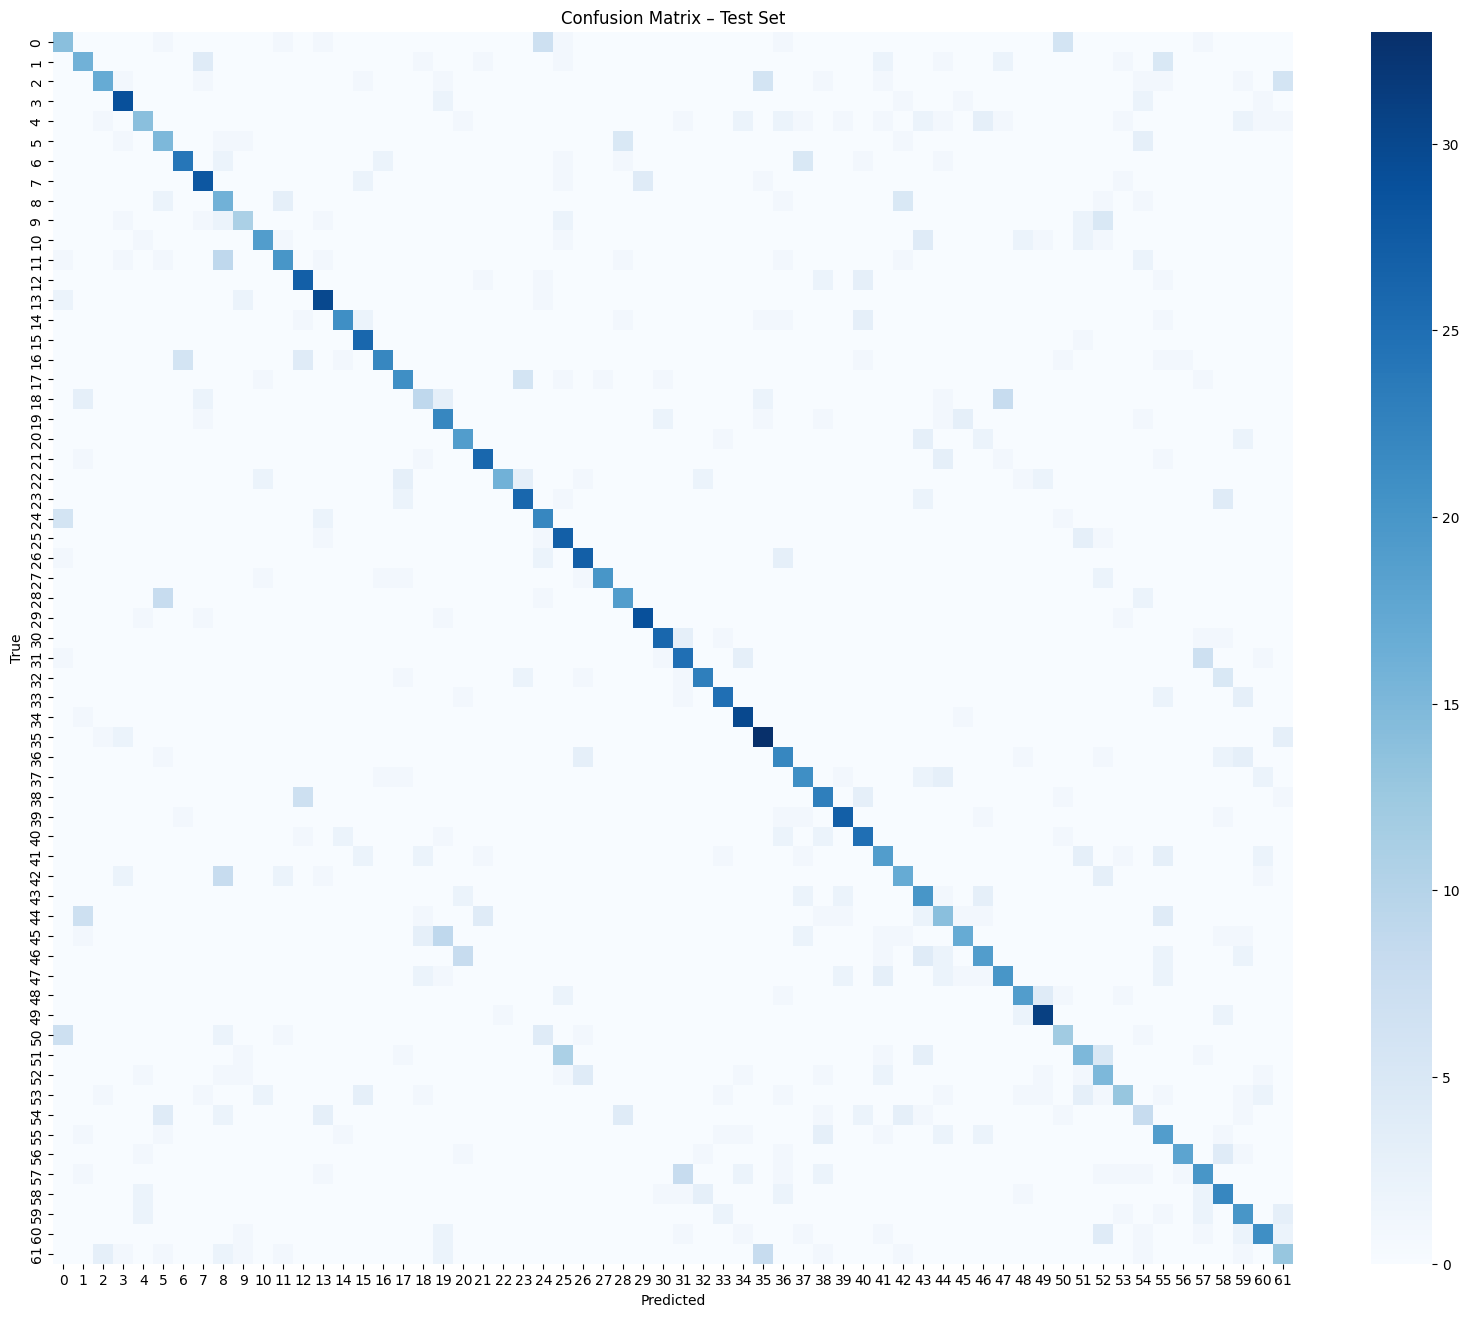

In [16]:
# FINAL EVALUATION – Test set

# 1. Recreate the model architecture (same as training)
class SimpleCNNImproved(nn.Module):
    def __init__(self, num_classes=62):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


# 2. Load the trained model
model = SimpleCNNImproved()
model.load_state_dict(torch.load('best_model_improved3.pth'))
model.eval()  # Evaluation mode (disables dropout)

print("Model loaded successfully")


# 3. Run predictions on test set
with torch.no_grad():
    outputs = model(X_test_t)
    _, predicted = torch.max(outputs, 1)
    predicted = predicted.numpy()
    y_true = y_test


# 4. Final metrics
test_accuracy = accuracy_score(y_true, predicted)
print("\nFINAL RESULTS ON TEST SET")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


# Detailed classification metrics
print("\nClassification Report:")
print(classification_report(y_true, predicted, target_names=encoder.classes_))


# 5. Confusion matrix
cm = confusion_matrix(y_true, predicted)

plt.figure(figsize=(20, 16))
sns.heatmap(cm, annot=False, cmap="Blues", fmt='d')
plt.title("Confusion Matrix – Test Set")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

#you can ajust the figsize parameter to make the plot larger or smaller